<a href="https://colab.research.google.com/github/Adasyam31494/Generative-AI-with-Large-Language-Models/blob/main/Training_a_GPT_Model_Variation_Using_the_Wine_Reviews_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q tensorflow

In [4]:
from google.colab import files
uploaded = files.upload()

Saving winemag-data_first150k.csv to winemag-data_first150k.csv
Saving winemag-data-130k-v2.csv to winemag-data-130k-v2.csv


In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [7]:
df = pd.read_csv("winemag-data_first150k.csv")

df = df.dropna(subset=['description'])

texts = df['description'].astype(str).tolist()
print("Number of reviews:", len(texts))
print("Sample review:", texts[0])


Number of reviews: 150930
Sample review: This tremendous 100% varietal wine hails from Oakville and was aged over three years in oak. Juicy red-cherry fruit and a compelling hint of caramel greet the palate, framed by elegant, fine tannins and a subtle minty tone in the background. Balanced and rewarding from start to finish, it has years ahead of it to develop further nuance. Enjoy 2022–2030.


In [8]:
texts = texts[:20000]

tokenizer = Tokenizer()
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)

maxlen = 40
vocab_size = len(tokenizer.word_index) + 1

input_sequences = []
target_words = []

for seq in sequences:
    for i in range(1, len(seq)):
        n_gram_seq = seq[:i+1]
        if len(n_gram_seq) == maxlen:
            input_sequences.append(n_gram_seq[:-1])
            target_words.append(n_gram_seq[-1])

input_sequences = pad_sequences(input_sequences, maxlen=maxlen-1, padding='pre')
target_words = keras.utils.to_categorical(target_words, num_classes=vocab_size)

print("Vocabulary size:", vocab_size)
print("Input shape:", input_sequences.shape)

Vocabulary size: 16355
Input shape: (10333, 39)


In [9]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

In [10]:
embed_dim = 64
num_heads = 2
ff_dim = 128

inputs = layers.Input(shape=(maxlen - 1,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
x = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
x = layers.LayerNormalization(epsilon=1e-6)(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dense(ff_dim, activation='relu')(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(vocab_size, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 39)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ token_and_position… │ (None, 39, 64)    │  1,049,280 │ input_layer[0][0] │
│ (TokenAndPositionE… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 39, 64)    │     33,216 │ token_and_positi… │
│ (MultiHeadAttentio… │                   │            │ token_and_positi… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 39, 64)    │        128 │ multi_head_atten… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │      8,320 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 16355)     │  2,109,795 │ dropout_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,200,739 (12.21 MB)

 Trainable params: 3,200,739 (12.21 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
history = model.fit(input_sequences, target_words, epochs=5, batch_size=64)

Epoch 1/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 23s 122ms/step - accuracy: 0.0589 - loss: 7.6561
Epoch 2/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - accuracy: 0.0651 - loss: 6.1461
Epoch 3/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 20s 122ms/step - accuracy: 0.0605 - loss: 5.9672
Epoch 4/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - accuracy: 0.0632 - loss: 5.7515
Epoch 5/5
162/162 ━━━━━━━━━━━━━━━━━━━━ 17s 105ms/step - accuracy: 0.0817 - loss: 5.4002


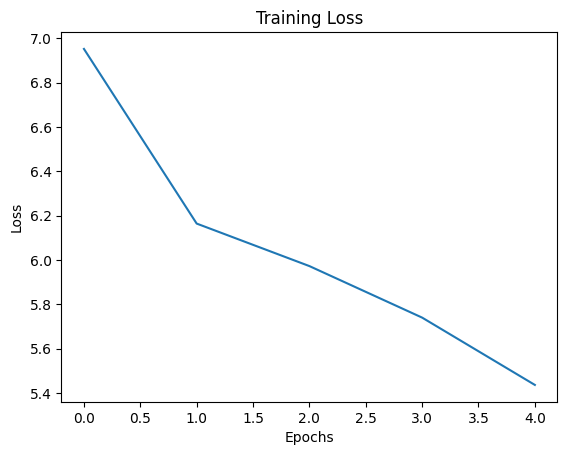

In [12]:
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('loss_curve.png')
plt.show()

In [13]:
def sample_with_temperature(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds + 1e-8) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    return np.random.choice(len(preds), p=preds)

def generate_text(seed_text, next_words=40, temperature=1.0):
    for _ in range(next_words):
        token_list = tokenizer.texts_to_sequences([seed_text])[0]
        token_list = pad_sequences([token_list], maxlen=maxlen - 1, padding='pre')
        predicted_probs = model.predict(token_list, verbose=0)[0]
        predicted_index = sample_with_temperature(predicted_probs, temperature)
        output_word = tokenizer.index_word.get(predicted_index, '')
        seed_text += " " + output_word
    return seed_text

In [14]:
seed = "This wine has a rich flavor of"

output_05 = generate_text(seed, temperature=0.5)
print("Temperature 0.5:\n", output_05)
with open("output_temp_05.txt", "w") as f:
    f.write(output_05)

output_10 = generate_text(seed, temperature=1.0)
print("\nTemperature 1.0:\n", output_10)
with open("output_temp_10.txt", "w") as f:
    f.write(output_10)

Temperature 0.5:
 This wine has a rich flavor of on nose and and on palate and and the palate of finishes cherry black herb tannins spicy pepper with sweetness vibrant finish lemon with fresh that with is toasty drink to that drink drink years from this 2018 from drink

Temperature 1.0:
 This wine has a rich flavor of along honeysuckle tastes pear streak are of and aromatic so spice blackberry next lush be complexity fresh complexity through integrate fruit chocolate effort red and with cherry also a flavor the texture and firm toasty a a or through herb
